In [1]:
# import functions:

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import statistics

### STEP 1:

We want to transform the output data format into a `networkx` object first.

In [3]:
def read_nefi_graph(tracing_file_name):
    '''
    Parameter:  
    ----------
    tracing_file_name: string, path to vein txt file, graph extracted from nefi
    
    Returns:
    ----------
    G_trace: nx graph, with graph attribute for dimensions (xmin, xmax, y_min, y_max, xy ratio)
    
    '''
    
    # read in output from nefi:
    G_trace = nx.read_multiline_adjlist(tracing_file_name, delimiter='|')
    
    # remove unwanted attr:
    for e in G_trace.edges:
        del G_trace.edges[e]['pixels']
        del G_trace.edges[e]['width']
        del G_trace.edges[e]['width_var']
        
    # add node node attr:
    name_map = {}
    for n in G_trace:
        name_map[n] = tuple(map(int, n[1:-1].split(', ')))
    
    # rename the node to coordinate tuples to replace the strings:
    G_trace = nx.relabel_nodes(G_trace, name_map)
    
    # add graph feature to help recovering the dimention ratio in plotting
    mins = np.min(np.array(list(G_trace.nodes())), 0)
    maxes = np.max(np.array(list(G_trace.nodes())), 0)
    
    G_trace.graph['x_min'] = mins[0]
    G_trace.graph['y_min'] = mins[1]
    
    G_trace.graph['x_max'] = maxes[0]
    G_trace.graph['y_max'] = maxes[1]
    
    G_trace.graph['ratio'] = (maxes[0] - mins[0]) / (maxes[1] - mins[1])
    
    return G_trace

In [53]:
# file path and name:



tracing_file_name = '/Users/lperez/Documents/CAMILASLAB/SAKET/DEVELOPMENT_BRANCHES/2_Month_Nefi_Files/leaf_venation_SH42.1-1.2_BRANCHES_#1_18h12m53s/Graph Filtering_keep_only_lcc_SH42.1-1.2_BRANCHES.txt'



In [7]:
#Path to the scale bar, to add normalizations
scale_bar = 'Graph Detection_guo_hall_graph_detection_Trial_measures.txt'

In [54]:
# read in the graph:
G_trace = read_nefi_graph(tracing_file_name)
#scale = read_nefi_graph(scale_bar)
##Find the number of nodes and edges,

#edges are the links (lines)
#Nodes are the points (ends)
N, K = G_trace.order(), G_trace.size()

print('The number of nodes is', N)
print('The number of edges is', K)
terminal_nodes = [x for x in G_trace.nodes() if G_trace.degree(x)==1]
len(terminal_nodes)
print('The number of terminal nodes is', len(terminal_nodes))



The number of nodes is 1317
The number of edges is 1364
The number of terminal nodes is 619


In [9]:
print(type(scale))

<class 'networkx.classes.graph.Graph'>


In [7]:
print(type(G_trace))

<class 'networkx.classes.graph.Graph'>


### STEP 2:

Now, let's visualize the graph.

In [8]:
def quick_plot(G):
    '''
    quick plotting for spatial graphs;
    since each node's named after it's coordinate, we can just use that to plot it's spatial position.
    '''
    node_positions = {}
    
    for node in G.nodes:
        node_positions[node] = node
    
    # plotting with figure dimentions matching the graph's dimension:
    fig, ax = plt.subplots(figsize=(8, 8/G.graph['ratio']))
    
    nx.draw(G, pos=node_positions, node_size= 20,  ax = ax) 
    
    plt.tight_layout()
    plt.show()   
        
    return

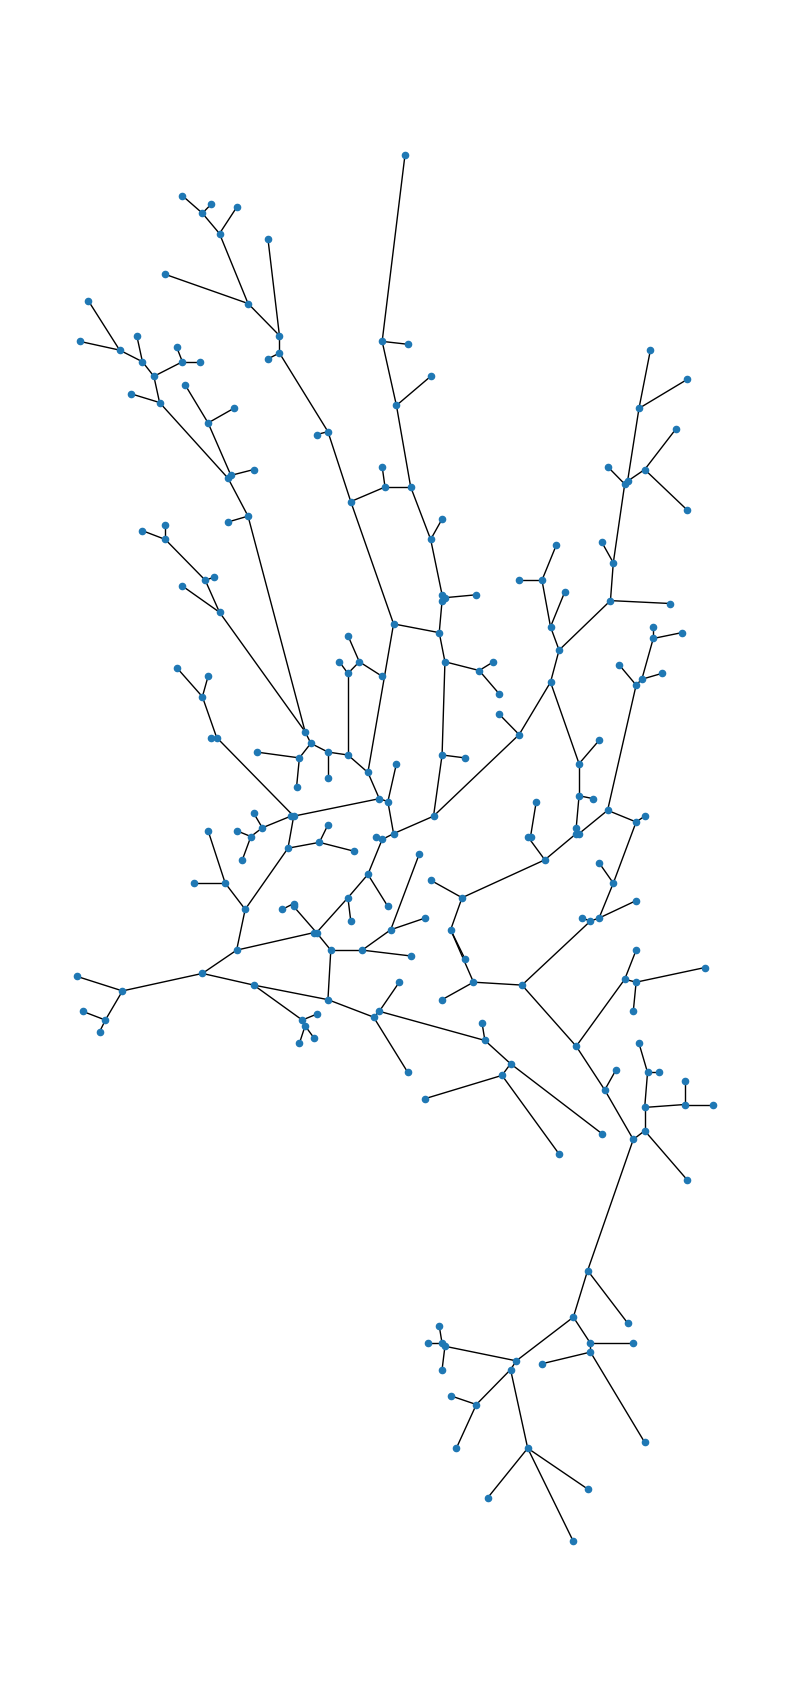

In [9]:
quick_plot(G_trace)

In [10]:
node_list = list(G_trace.nodes)

In [11]:
import scipy

In [12]:
convex_hull = scipy.spatial.ConvexHull(node_list)

In [13]:
idxes = convex_hull.vertices

In [14]:
boundary = np.array(node_list)[idxes]

In [15]:
boundary = boundary.tolist()

In [16]:
boundary.append(boundary[0])

In [17]:
boundary = np.array(boundary)

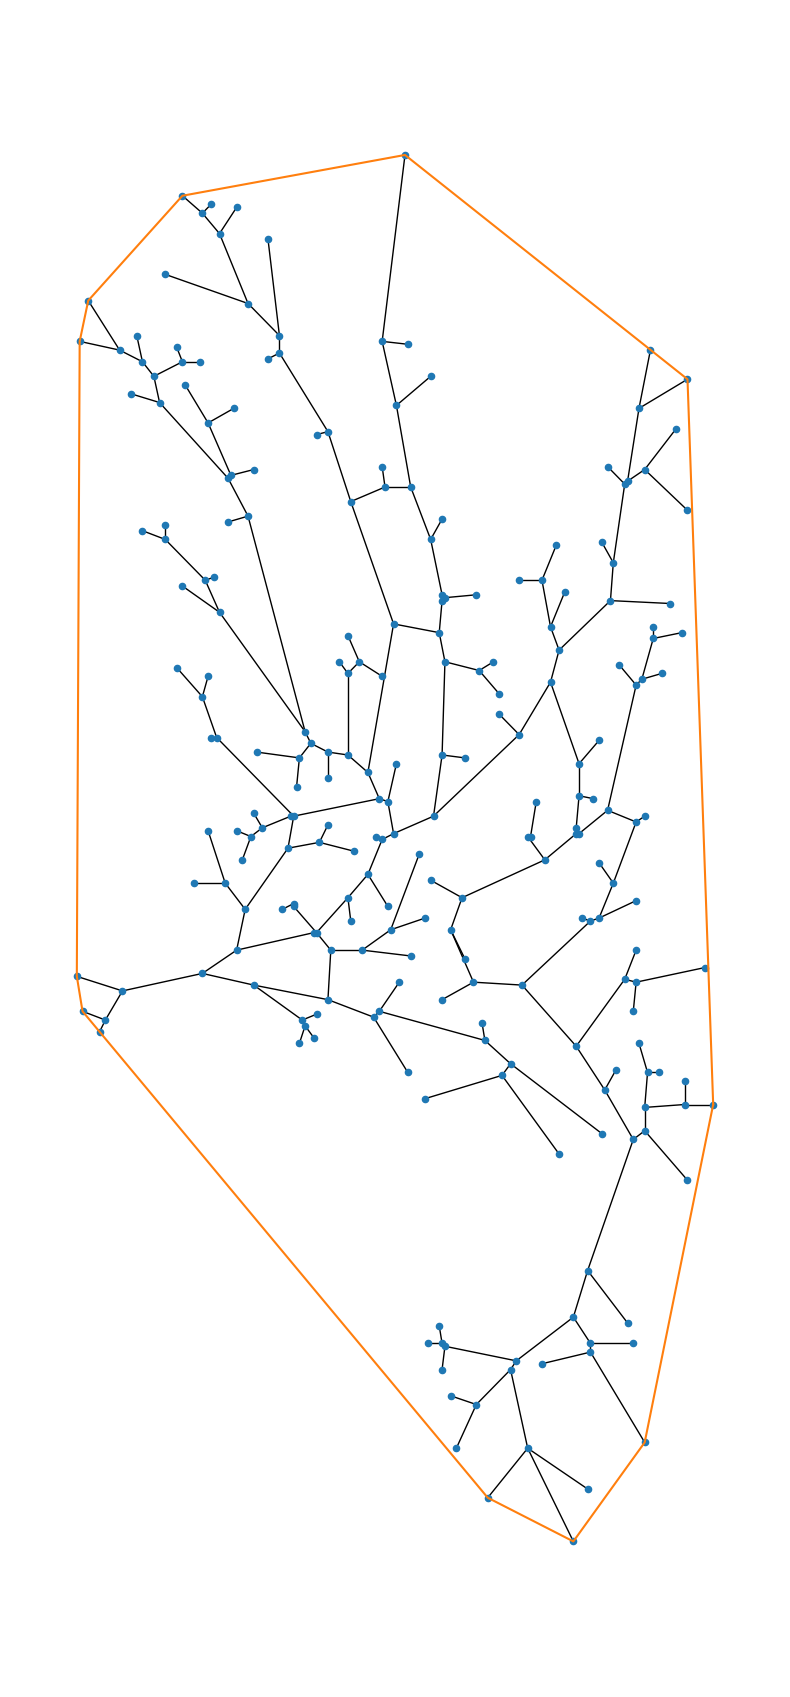

In [18]:
node_positions = {}

for node in G_trace.nodes:
    node_positions[node] = node

# plotting with figure dimentions matching the graph's dimension:
fig, ax = plt.subplots(figsize=(8, 8/G_trace.graph['ratio']))

nx.draw(G_trace, pos=node_positions, node_size= 20,  ax = ax) 

plt.plot(boundary[:,0], boundary[:,1], c = 'C1')

plt.tight_layout()
plt.show()   

## STEP 3: Calculation of properties


First, we need to include information about the actual size of our network. For this, we will use the network layer with only three edges (longer edge = length of the mammary gland, medium edge = width of the mammary gland, short edge = scale bar, which we do know the length of in micrometers). This will allow us to convert the edge length from pixels to metric units.

### Length of edges

1 mm is 59.656856000000005 pixels long


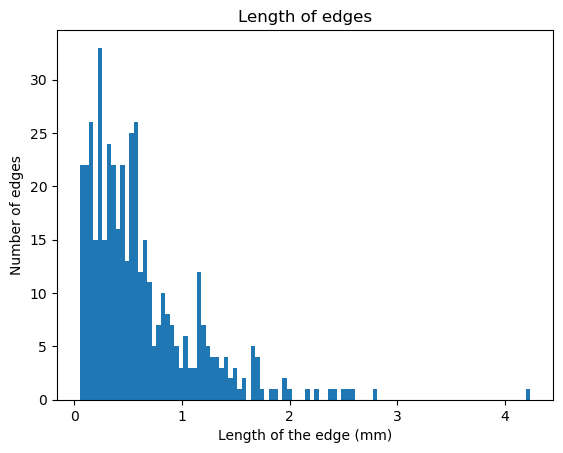

In [25]:
###LENGTH OF THE SCALE BAR (smallest), HEIGHT (largest), WIDTH (medium)
#Length distribution of the edges (ducts)
arc_length = nx.get_edge_attributes(scale,'length')
scale_lengths = list(arc_length.values())
scale_lengths.sort( reverse = True)
scale_lengths

###LENGTH OF THE SCALE BAR (smallest), HEIGHT (largest), WIDTH (medium)
#Length distribution of the edges (ducts)
arc_length = nx.get_edge_attributes(G_trace,'length')
edge_lengths = arc_length.values() 
##Now, convert the length of the edges (currently in pixels) to micrometers
print('1 mm is', scale_lengths[2], 'pixels long')

#Convert edge lengths into milimeters
duct_lengths = list(edge_lengths)
duct_lengths_mm = np.divide(duct_lengths, scale_lengths[2])
duct_lengths_mm

#Plot a histogram with the length distribution of edges in milimeters
plt.hist(duct_lengths_mm, bins = 100)
plt.title('Length of edges')
plt.xlabel('Length of the edge (mm)')
plt.ylabel('Number of edges')
plt.show()

### Normalize by total area of the mammary gland

In [29]:
##For now, consider area as a rectangle
MG_area = scale_lengths[0]*scale_lengths[1]
MG_area

#Now, compute total length of the whole branching tree
total_tree_length = sum(duct_lengths_mm)

##Now, divide the total length of the branching tree by the area of the tree
norm_tree = (total_tree_length / MG_area)*1000
norm_tree

0.17024368873539178

### Analysis of branching degree

In [19]:
# number of connected components, if >1 then there are smaller networks not connected:
nx.number_connected_components(G_trace)

1

In [20]:
# number of cycles, which is something that you might want to remove bc you know
# that the tree network should not have cycles! 
# but that also depend on how sensetive the properties that you care depend on 
# whether there are cycles.

cycles = list(nx.cycle_basis(G_trace))

In [21]:
len(cycles)

7

In [22]:
# plot the degree distribution:
degree_sequence = sorted((d for n, d in G_trace.degree()), reverse=True)

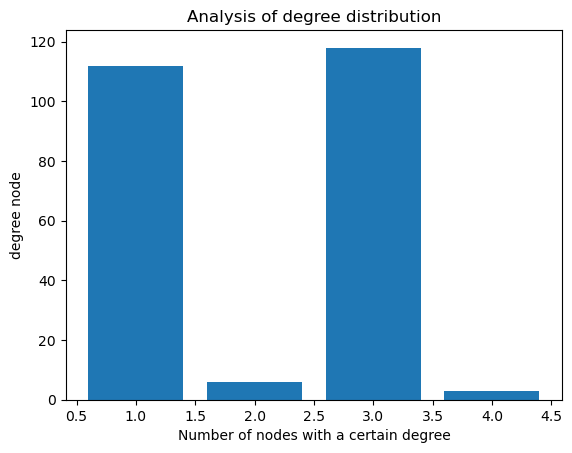

In [23]:
plt.bar(*np.unique(degree_sequence, return_counts=True), label = 'Degree distribution')
plt.title('Analysis of degree distribution')
plt.xlabel('Number of nodes with a certain degree')
plt.ylabel('degree node')
plt.show()

### Analysis of number of edges and ducts

In [24]:
##Find the number of nodes and edges,

#edges are the links (lines)
#Nodes are the points (ends)
N, K = G_trace.order(), G_trace.size()

print('The number of nodes is', N)
print('The number of edges is', K)

The number of nodes is 239
The number of edges is 245


In [25]:
##Find terminal nodes, which I am assuming will be the actual alveoli

terminal_nodes = [x for x in G_trace.nodes() if G_trace.degree(x)==1]
len(terminal_nodes)

112

In [23]:
##Basic analysis of degree distribution
#in_degrees= G_trace.in_degree() # dictionary node:degree
#in_values= sorted(set(in_degrees.values()))
#in_hist= [in_degrees.values().count(x) for x in in_values]

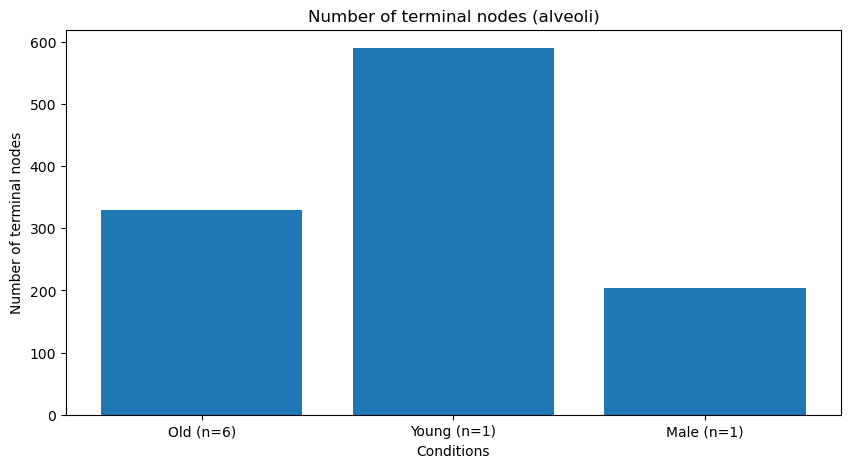

In [53]:
old_terminal = [348, 345, 250, 287, 362, 380]
young_terminal = 590
male_terminal = 204
data = {'Old (n=6)':statistics.mean(old_terminal), 'Young (n=1)':590, 'Male (n=1)':204}

courses = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(courses, values)
plt.title('Number of terminal nodes (alveoli)')
plt.xlabel('Conditions')
plt.ylabel('Number of terminal nodes')
plt.show()

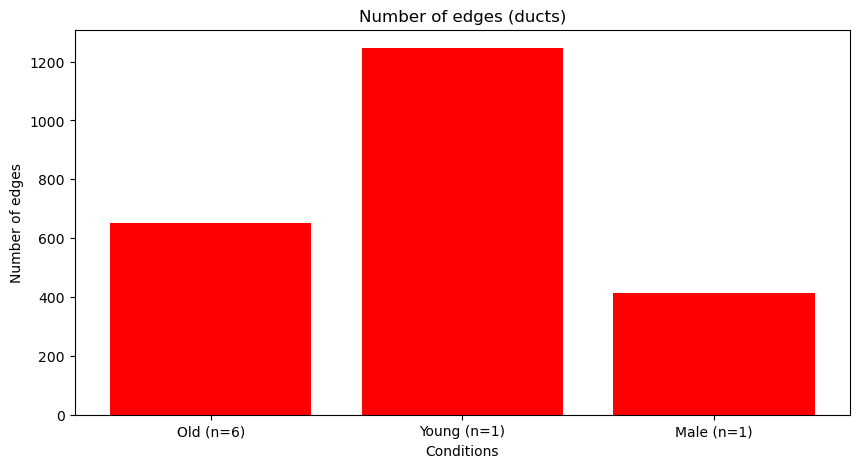

In [54]:
old_terminal = [700, 625, 692, 786, 558, 540]
young_terminal = 1246
male_terminal = 413
data2 = {'Old (n=6)':statistics.mean(old_terminal), 'Young (n=1)':1246, 'Male (n=1)':413}

courses = list(data2.keys())
values = list(data2.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(courses, values, color = 'r')
plt.title('Number of edges (ducts)')
plt.xlabel('Conditions')
plt.ylabel('Number of edges')
plt.show()

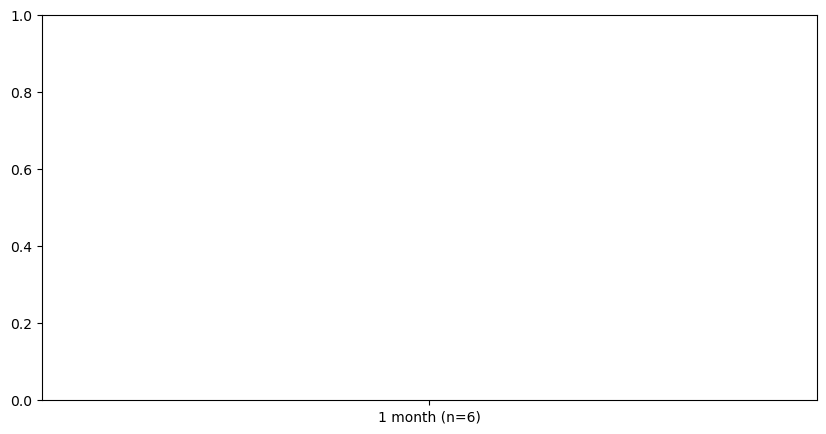

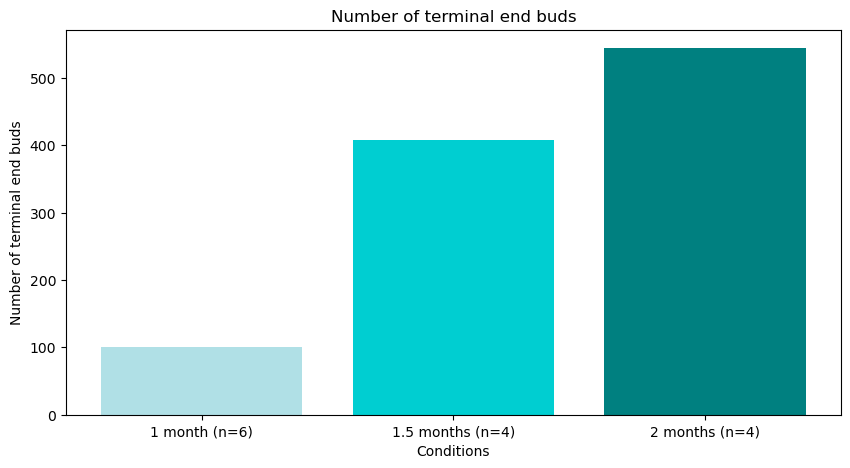

In [59]:
month1_terminal = [112, 69, 104, 95, 49, 175]
month1_5_terminal = [404, 381, 502, 346]
month2_terminal = [532, 539, 487, 619]
data2 = {'1 month (n=6)':statistics.mean(month1_terminal), '1.5 months (n=4)':statistics.mean(month1_5_terminal), '2 months (n=4)':statistics.mean(month2_terminal)}

courses = list(data2.keys())
values = list(data2.values())
fig = plt.figure(figsize = (10, 5))
bar_colors = ['powderblue', 'darkturquoise', 'teal']
plt.bar(courses, values, color = bar_colors)
plt.title('Number of terminal end buds')
plt.xlabel('Conditions')
plt.ylabel('Number of terminal end buds')
plt.show()